# Surviving the Titanic Shipwreck - Experiment with Passenger Profiles

Note: you can install the requirements file for this notebook if you want to install all the libraries at once. Open a new terminal window, navigate to the folder with the "requirements_jupyter.txt" and run the following command:

***pip3 install -r requirements_jupyter.txt***


In [1]:
# !pip3 install -r requirements_jupyter.txt

In [2]:
#!/usr/bin/env python
import matplotlib.pyplot as plt; plt.rcdefaults()
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from numpy import genfromtxt
from sklearn.feature_selection import RFE


In [3]:
# download the data from the Vanderbilt University Department of Biostatistics servers
# if you cannot download the files try doing it manually
# if have an ssl error  Mac try fix: "/Applications/Python\ 3.6/Install\ Certificates.command"
titanic_df = pd.read_csv('http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.csv')
 

In [4]:
# take a peek at the data
titanic_df.head() 

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [5]:
titanic_df['embarked'].value_counts()

S    914
C    270
Q    123
Name: embarked, dtype: int64

<H1>Data Exploration</H1>

In [6]:
# feature data types
titanic_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
pclass       1309 non-null int64
survived     1309 non-null int64
name         1309 non-null object
sex          1309 non-null object
age          1046 non-null float64
sibsp        1309 non-null int64
parch        1309 non-null int64
ticket       1309 non-null object
fare         1308 non-null float64
cabin        295 non-null object
embarked     1307 non-null object
boat         486 non-null object
body         121 non-null float64
home.dest    745 non-null object
dtypes: float64(3), int64(4), object(7)
memory usage: 143.2+ KB


In [7]:
# summary of quantitative data
titanic_df.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881138,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413493,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [8]:
# count missing data
titanic_missing_count = titanic_df.isnull().sum().sort_values(ascending=False)
pd.DataFrame({'Percent Missing':titanic_missing_count/len(titanic_df)})


,Percent Missing
body,0.907563
cabin,0.774637
boat,0.628724
home.dest,0.430863
age,0.200917
embarked,0.001528
fare,0.000764
ticket,0.000000
parch,0.000000
sibsp,0.000000


In [9]:
titanic_df['cabin'].head()

0         B5
1    C22 C26
2    C22 C26
3    C22 C26
4    C22 C26
Name: cabin, dtype: object

In [10]:
titanic_feature_count = titanic_df.groupby('cabin')['cabin'].count().reset_index(name = "Group_Count")
titanic_feature_count.sort_values('Group_Count', ascending=False).head(10)

,cabin,Group_Count
80,C23 C25 C27,6
184,G6,5
47,B57 B59 B63 B66,5
60,B96 B98,4
183,F4,4
181,F33,4
180,F2,4
79,C22 C26,4
117,D,4
102,C78,4


In [11]:
titanic_feature_count = titanic_df.groupby('name')['name'].count().reset_index(name = "Group_Count")
titanic_feature_count.sort_values('Group_Count', ascending=False).head(10)

,name,Group_Count
261,"Connolly, Miss. Kate",2
638,"Kelly, Mr. James",2
0,"Abbing, Mr. Anthony",1
879,"O'Brien, Mrs. Thomas (Johanna ""Hannah"" Godfrey)",1
877,"O'Brien, Mr. Thomas",1
876,"Nysveen, Mr. Johan Hansen",1
875,"Nysten, Miss. Anna Sofia",1
874,"Nye, Mrs. (Elizabeth Ramell)",1
873,"Novel, Mr. Mansouer",1
872,"Nourney, Mr. Alfred (""Baron von Drachstedt"")",1


<H1>Data Preparation</H1>

In [12]:
# strip first letter from cabin number if there
titanic_df['cabin'] = titanic_df['cabin'].replace(np.NaN, 'U') 
titanic_df['cabin'] = [ln[0] for ln in titanic_df['cabin'].values]
titanic_df['cabin'] = titanic_df['cabin'].replace('U', 'Unknown') 
titanic_df['cabin'].head()

0    B
1    C
2    C
3    C
4    C
Name: cabin, dtype: object

In [13]:
titanic_feature_count = titanic_df.groupby('cabin')['cabin'].count().reset_index(name = "Group_Count")
titanic_feature_count.sort_values('Group_Count', ascending=False).head(10)


,cabin,Group_Count
8,Unknown,1014
2,C,94
1,B,65
3,D,46
4,E,41
0,A,22
5,F,21
6,G,5
7,T,1


In [14]:

# create title field and get extract title name
titanic_df['title'] = [ln.split()[1] for ln in titanic_df['name'].values]
titanic_df['title'].value_counts()
titanic_df['title'] = [title if title in ['Mr.', 'Miss.', 'Mrs.', 'Master.', 'Dr.', 'Rev.'] else 'Unknown'
                       for title in titanic_df['title'].values ]
titanic_df['title'].head()

0      Miss.
1    Master.
2      Miss.
3        Mr.
4       Mrs.
Name: title, dtype: object

In [15]:



# create isfemale field and use numerical values
titanic_df['isfemale'] = np.where(titanic_df['sex'] == 'female', 1, 0)

# drop features not needed for model 
titanic_df = titanic_df[[f for f in list(titanic_df) if f not in ['sex', 'name', 'boat','body', 'ticket', 'home.dest']]]

# make pclass actual categorical column
titanic_df['pclass'] = np.where(titanic_df['pclass'] == 1, 'First', 
                                np.where(titanic_df['pclass'] == 2, 'Second', 'Third'))


titanic_df['embarked'] = titanic_df['embarked'].replace(np.NaN, 'Unknown') 


titanic_df.head()

,pclass,survived,age,sibsp,parch,fare,cabin,embarked,title,isfemale
0,First,1,29.00,0,0,211.3375,B,S,Miss.,1
1,First,1,0.92,1,2,151.5500,C,S,Master.,0
2,First,0,2.00,1,2,151.5500,C,S,Miss.,1
3,First,0,30.00,1,2,151.5500,C,S,Mr.,0
4,First,0,25.00,1,2,151.5500,C,S,Mrs.,1


## Making Dummy Fields

In [16]:
pd.get_dummies(titanic_df['cabin'], columns=['cabin'], drop_first=False).head(10)

,A,B,C,D,E,F,G,T,Unknown
0,0,1,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0
6,0,0,0,1,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0
8,0,0,1,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,1


<H1>Modeling with Logistic Regression</H1>

In [17]:
# get average survival rate to compare to prediction values
average_survival_rate = np.mean(titanic_df['survived']) * 100
print('Average probability of surviving Titanic trip: %.2f percent' % average_survival_rate)


Average probability of surviving Titanic trip: 38.20 percent


In [18]:
def prepare_data_for_model(raw_dataframe, target_columns, drop_first = True, make_na_col = True):
    # dummy all categorical fields 
    dataframe_dummy = pd.get_dummies(raw_dataframe, columns=target_columns, 
                                     drop_first=drop_first, 
                                     dummy_na=make_na_col)
    return (dataframe_dummy)

# create dummy features 
titanic_ready_df = prepare_data_for_model(titanic_df, target_columns=['pclass', 'cabin', 'embarked', 'title'])
titanic_ready_df = titanic_ready_df.dropna() 
list(titanic_ready_df)

['survived',
 'age',
 'sibsp',
 'parch',
 'fare',
 'isfemale',
 'pclass_Second',
 'pclass_Third',
 'pclass_nan',
 'cabin_B',
 'cabin_C',
 'cabin_D',
 'cabin_E',
 'cabin_F',
 'cabin_G',
 'cabin_T',
 'cabin_Unknown',
 'cabin_nan',
 'embarked_Q',
 'embarked_S',
 'embarked_Unknown',
 'embarked_nan',
 'title_Master.',
 'title_Miss.',
 'title_Mr.',
 'title_Mrs.',
 'title_Rev.',
 'title_Unknown',
 'title_nan']

In [19]:
# split data into train and test portions and model
from sklearn.model_selection import train_test_split
features = [feat for feat in list(titanic_ready_df) if feat != 'survived']
X_train, X_test, y_train, y_test = train_test_split(titanic_ready_df[features], 
                                                 titanic_ready_df[['survived']], 
                                                 test_size=0.5, 
                                                 random_state=42)
X_train.head(3)


,age,sibsp,parch,fare,isfemale,pclass_Second,pclass_Third,pclass_nan,cabin_B,cabin_C,...,embarked_S,embarked_Unknown,embarked_nan,title_Master.,title_Miss.,title_Mr.,title_Mrs.,title_Rev.,title_Unknown,title_nan
455,63.0,1,0,26.000,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
83,64.0,1,1,26.550,1,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
1228,31.0,0,0,7.925,0,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0


In [20]:
print(y_train.head(3))

      survived
455          0
83           1
1228         1


In [21]:
 

from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train.values.ravel())


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [22]:
# predict on test portion and get accuracy score
y_pred = lr_model.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}%'
      .format(lr_model.score(X_test, y_test)*100))


Accuracy of logistic regression classifier on test set: 79.35%


<H2>Interpretation of Model’s Coefficients</H2>

In [23]:
coefs = pd.DataFrame({'Feature':features, 'Coef':lr_model.coef_[0]})
print('Positive Features')
coefs.sort_values('Coef', ascending=False).head(7)

Positive Features


,Feature,Coef
4,isfemale,1.943663
21,title_Master.,1.819171
24,title_Mrs.,0.956866
10,cabin_D,0.729880
11,cabin_E,0.397124
12,cabin_F,0.181792
13,cabin_G,0.161272


In [24]:
print('Negative Features')
coefs.sort_values('Coef', ascending=False).tail(7)

Negative Features


,Feature,Coef
8,cabin_B,-0.354787
1,sibsp,-0.546999
9,cabin_C,-0.690267
6,pclass_Third,-0.739187
23,title_Mr.,-0.761340
17,embarked_Q,-1.030018
15,cabin_Unknown,-1.225105


<H2>Recursive Feature Elimination (RFE) method</H2>

In [25]:
from sklearn.feature_selection import RFE
rfe = RFE(lr_model, 1)
rfe = rfe.fit(X_train, np.ravel(y_train))

# get feature rank in order from elimination process
feature_rank = pd.DataFrame({'Feature':list(X_train),'Rank':rfe.ranking_ })
feature_rank = feature_rank.sort_values('Rank')
feature_rank.head()


,Feature,Rank
4,isfemale,1
21,title_Master.,2
15,cabin_Unknown,3
17,embarked_Q,4
6,pclass_Third,5


<H1>Predict using Fictional Passenger</H1>

In [26]:
# Create your own passenger - ranges and options available
x_predict_pclass = 'Third' # First, Second, Third
x_predict_is_female=1 # 0-1
x_predict_age=10 # 0-100
x_predict_sibsp=3 #  (0-8)
x_predict_parch = 0 #  (0-9)
x_predict_fare = 200 #  (0-500)
x_predict_cabin = 'A' # 'A', 'C', 'B', 'E', 'D', 'G', 'F', 'T', 'Z' 
x_predict_embarked = 'Q' #  'Q', 'S', 'C' # Cherbourg Queenstown Southampton
x_predict_title = 'Mrs.' # ['Mr.', 'Miss.', 'Mrs.', 'Master.', 'Dr.', 'Rev.', Unknown]
 

In [27]:
# Create your own passenger
x_predict_pclass = 'Third' 
x_predict_is_female=0  
x_predict_age=50 
x_predict_sibsp=3 
x_predict_parch = 0  
x_predict_fare = 200  
x_predict_cabin = 'A'  
x_predict_embarked = 'Q'  
x_predict_title = 'Mr.'  

In [28]:
# make a copy of the original data set in order to create dummy categories that are the same as seen on 
# original data
titanic_df_tmp = titanic_df.copy()
# add new row to titanic df
titanic_df_tmp = titanic_df_tmp[['pclass', 'age', 'sibsp', 'parch', 'fare', 'cabin', 'embarked', 'title', 'isfemale', 'survived']] 

titanic_fictional_df = pd.DataFrame([[x_predict_pclass, 
                                     x_predict_age,
                                     x_predict_sibsp,
                                     x_predict_parch,
                                     x_predict_fare,
                                     x_predict_cabin,
                                     x_predict_embarked,
                                     x_predict_title,
                                     x_predict_is_female,
                                     0]], columns = ['pclass', 'age', 'sibsp', 'parch', 'fare', 'cabin', 'embarked', 'title', 'isfemale', 'survived']) 


In [29]:
# titanic_df_tmp.append(titanic_fictional_df)
titanic_df_tmp = pd.concat([titanic_fictional_df, titanic_df_tmp], ignore_index=True)
# titanic_df_tmp = pd.get_dummies(titanic_df_tmp)
titanic_df_tmp = prepare_data_for_model(titanic_df_tmp, target_columns=['pclass', 'cabin', 'embarked', 'title'])

Y_pred = lr_model.predict_proba(titanic_df_tmp[features].head(1))
probability_of_surviving_fictional_character = Y_pred[0][1] * 100
print('Probability of surviving Titanic voyage: %.2f percent' % probability_of_surviving_fictional_character)



Probability of surviving Titanic voyage: 3.10 percent


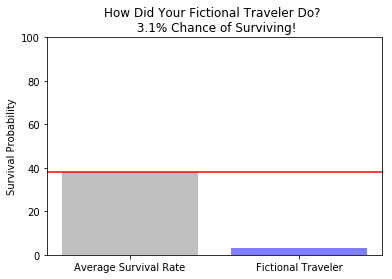

In [30]:
fig = plt.figure()
objects = ('Average Survival Rate', 'Fictional Traveler')
y_pos = np.arange(len(objects))
performance = [average_survival_rate, probability_of_surviving_fictional_character]
 
ax = fig.add_subplot(111)
colors = ['gray', 'blue']
plt.bar(y_pos, performance, align='center', color = colors, alpha=0.5)
plt.xticks(y_pos, objects)
plt.axhline(average_survival_rate, color="r")
plt.ylim([0,100])
plt.ylabel('Survival Probability')
plt.title('How Did Your Fictional Traveler Do? \n ' + str(round(probability_of_surviving_fictional_character,2)) + '% Chance of Surviving!')
 
plt.show()

## Preparing data set for the cloud and making it pandas free!

In [31]:
titanic_df = pd.read_csv('http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.csv')

# get title
titanic_df['title'] = [ln.split()[1] for ln in titanic_df['name'].values]
titanic_df['title'] = [title if title in ['Mr.', 'Miss.', 'Mrs.', 'Master.', 'Dr.', 'Rev.'] else 'Unknown'
                   for title in titanic_df['title'].values ]

# strip first letter from cabin number if there
titanic_df['cabin'] = titanic_df['cabin'].replace(np.NaN, 'U')
titanic_df['cabin'] = [ln[0] for ln in titanic_df['cabin'].values]
titanic_df['cabin'] = titanic_df['cabin'].replace('U', 'Unknown')

titanic_df['isfemale'] = np.where(titanic_df['sex'] == 'female', 1, 0)

# drop features not needed for model
titanic_df = titanic_df[[f for f in list(titanic_df) if f not in ['sex', 'name', 'boat','body', 'ticket', 'home.dest']]]

# make pclass actual categorical column
titanic_df['pclass'] = np.where(titanic_df['pclass'] == 1, 'First',
                            np.where(titanic_df['pclass'] == 2, 'Second', 'Third'))

# get average survival rate
average_survival_rate = np.mean(titanic_df['survived']) * 100

titanic_df['embarked'] = titanic_df['embarked'].replace(np.NaN, 'Unknown')

# prepare training data
titanic_ready_df = prepare_data_for_model(titanic_df, target_columns=['pclass', 'cabin', 'embarked', 'title'])
titanic_ready_df = titanic_ready_df.dropna() 

# save dataframe without header or index
titanic_ready_df.to_csv('titanic3.csv', header=False, index=False)

In [32]:
# load the data as an array instead of a data frame
from numpy import genfromtxt
titanic_array = genfromtxt('titanic3.csv', delimiter=',')


In [33]:
# split data into train and test portions and model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split([item[1:] for item in titanic_array], 
                                                 [item[0] for item in titanic_array], 
                                                 test_size=0.5, 
                                                 random_state=42)
 

In [34]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [35]:
# let's check that our model works by feeding an array instead of a dataframe
average_survival_rate = np.mean([item[0] for item in titanic_array]) 

X_train, X_test, y_train, y_test = train_test_split([item[1:] for item in titanic_array], 
                                             [item[0] for item in titanic_array], 
                                             test_size=0.5, 
                                             random_state=42)


# fit model only once
lr_model.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [36]:
# check that we can get the average survival rate without pandas
np.mean([item[0] for item in titanic_array])  

0.40861244019138754